# **COMS 4995 Final Project: Medical Imaging**
Steven Liu (xl2948)

In this project I will try to reimplement the medical imaging project mentioned in the paper "Detecting Cancer Metastases on Gigapixel Pathology Images." 

We will use two approaches: 

(1) Using only one level (level 4). We use relatively small dataset than the paper did and use transfer learning with the InceptionV3 model. We collect all patches at level 4, shuffle them, and generate training/validation/test set.

(2) Using three levels (level 3, 4, and 5). We pick a few images as the training set, a few as the validation set, and a few as the test set.

# Preparation

## Install & Imports
First we install the OpenSlide C library and Python bindings for zooming slides:

In [ ]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (174 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 160690 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import random
from scipy.ndimage.interpolation import rotate
import tensorflow as tf
from random import randrange
import scipy

##Download files
Now we mount Google Drive and download the files needed. We need all slides and their corresponding masks. There are 21 slides and corresponding mask files.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check the slides folder
!ls /content/drive/MyDrive/slides_copy3

 tumor_001-020.tiff   tumor_031.tif	   tumor_081_mask.tif
 tumor_001_mask.tif   tumor_031.xml	   tumor_081.tif
 tumor_001.tiff       tumor_035_mask.tif   tumor_081.xml
 tumor_001.xml	      tumor_035.tif	   tumor_084_mask.tif
 tumor_002_mask.tif   tumor_035.xml	   tumor_084.tif
 tumor_002.tif	     'tumor_038(1).xml'    tumor_084.xml
 tumor_002.xml	      tumor_038.tif	   tumor_091_mask.tif
 tumor_005_mask.tif   tumor_038.xml	   tumor_091.tif
 tumor_005.tif	      tumor_057_mask.tif   tumor_091.xml
 tumor_005.xml	      tumor_057.tif	   tumor_094_mask.tif
 tumor_012_mask.tif   tumor_057.xml	   tumor_094.tif
 tumor_012.tif	      tumor_059_mask.tif   tumor_094.xml
 tumor_012.xml	      tumor_059.tif	   tumor_096_mask.tif
 tumor_016_mask.tif   tumor_059.xml	   tumor_096.tif
 tumor_016.tif	      tumor_064_mask.tif   tumor_096.xml
 tumor_016.xml	      tumor_064.tif	   tumor_099.xml
 tumor_019_mask.tif   tumor_064.xml	   tumor_101_mask.tif
 tumor_019.tif	      tumor_075_mask.tif   tumor_101.tif
 t

We list all slide numbers and download the files:

In [ ]:
# All slide numbers
slide_number = ['001', '002', '005', '012', '016', '019', '023', '031', '035','057', '059', '064', '075', '078', '081', '084', '091', '094', '096','101', '110']

# List to hold all slides
slides = []

# List to hold all masks
masks = []

for number in slide_number:
    print('=' * 50)

    # Local paths
    slide_local_path = 'tumor_' + number + '.tif'
    mask_local_path = 'tumor_' + number + '_mask.tif'

    # Paths on Google Drive
    slide_drive_path = '/content/drive/MyDrive/slides/tumor_' + number + '.tif'
    mask_drive_path = '/content/drive/MyDrive/slides/tumor_' + number + '_mask.tif'

    # Download the slide we don't have it on Colab
    if not os.path.exists(slide_local_path) and os.path.exists(slide_drive_path):
        print('[Downloading', slide_local_path, ']')
        !gsutil cp {slide_drive_path} .
    else:
        print('[Downloaded', slide_local_path, ']')

    # Append slide
    slides.append(open_slide(slide_local_path))

    # Download the mask we don't have it on Colab
    if not os.path.exists(mask_local_path) and os.path.exists(mask_drive_path):
        print('[Downloading', mask_local_path, ']')
        !gsutil cp {mask_drive_path} .
    else:
        print('[Downloaded', mask_local_path, ']')

    # Append mask
    masks.append(open_slide(mask_local_path))

[Downloading tumor_001.tif ]
Copying file:///content/drive/MyDrive/slides/tumor_001.tif...
-
Operation completed over 1 objects/3.0 GiB.                                      
[Downloading tumor_001_mask.tif ]
Copying file:///content/drive/MyDrive/slides/tumor_001_mask.tif...
-
Operation completed over 1 objects/93.8 MiB.                                     
[Downloading tumor_002.tif ]
Copying file:///content/drive/MyDrive/slides/tumor_002.tif...
-
Operation completed over 1 objects/1.6 GiB.                                      
[Downloading tumor_002_mask.tif ]
Copying file:///content/drive/MyDrive/slides/tumor_002_mask.tif...
-
Operation completed over 1 objects/93.2 MiB.                                     
[Downloading tumor_005.tif ]
Copying file:///content/drive/MyDrive/slides/tumor_005.tif...
-
Operation completed over 1 objects/1.4 GiB.                                      
[Downloading tumor_005_mask.tif ]
Copying file:///content/drive/MyDrive/slides/tumor_005_mask.tif...
-
Op

Sanity check

In [ ]:
# The length of the slide list should equal to the number of indices
assert len(slides) == len(slide_number)

## Define functions
There are a few useful cells in the starter code. We paste them here for later uses:

In [ ]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [ ]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

We also define the functions for plotting the slides, the masks, and the overlayed images.

In [ ]:
# Function to plot an image
def plot_slide(slide, level, mask=False, plot=False):
    image = read_slide(slide, 
                            x=0, 
                            y=0, 
                            level=level, 
                            width=slide.level_dimensions[level][0], 
                            height=slide.level_dimensions[level][1])
    
    if mask:
        image = image[:,:,0]

    if plot:
        plt.figure(figsize=(10,10), dpi=100)
        plt.imshow(image)

    return image

# Function to plot overlay
def plot_overlay(slide_1, slide_2):
    plt.figure(figsize=(10,10), dpi=100)
    plt.imshow(slide_1)
    plt.imshow(slide_2, cmap='jet', alpha=0.5) # Red regions contains cancer.

From my experiments, I found that the mask has [0 0 0] on normal batches, and [1 1 1] on cancerous batches. We will construct the heatmap in a similar way:

In [ ]:
def plot_heatmap(width, level, i, threshold):

    # Get width and height, and number of blocks on each direction
    slide_width = slides[i].level_dimensions[level][0]
    slide_height = slides[i].level_dimensions[level][1]
    num_blocks_horizontal = int(slide_width/width)
    num_blocks_vertical = int(slide_height/width)

    # We initialize the heatmap to be all 0 and of the same size as the slide
    heatmap = np.zeros((slide_height, slide_width, 3))

    for j in range(num_blocks_vertical-1):
        for k in range(num_blocks_horizontal-1):
            # Get positions
            left = k * width
            top = j * width

            # Read slide
            slide_image = read_slide(slides[i], 
                                     x=left*2**level,
                                     y=top*2**level, 
                                     level=level, 
                                     width=width, 
                                     height=width)
            
            # Calculate the precetage of tissue pixels
            tissue_pixels = find_tissue_pixels(slide_image)
            percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100

            if percent_tissue > threshold:
                X_test = np.asarray([slide_image]) # Put slide_image into a numpy list for training
                output = model.predict(X_test) # We get a list with only one element (the predicted label)
                pred = output[0] # Get the label
                # If the label is over 0.5, we consider it cancerous
                if pred > 0.5:
                    heatmap[top:top+width, left:left+width, :] = np.ones((width, width,3))
    
    # Overlay the heatmap with the mask
    mask_image = plot_slide(masks[i], level, mask=True, plot=False)
    plot_overlay(mask_image, heatmap)

# Approach 1: Level 4 + InceptionV3

## Checking Slide & Mask Levels

After downloading them, we check the levels of slides and masks as the starter code did. We will see that in many cases, the slide and the mask might have different number of levels, as is shown below:

In [ ]:
for i in range(len(slides)):
    slide = slides[i]
    tumor_mask = masks[i]

    print('='*50)
    print("Read WSI from tumor_%s with width: %d, height: %d" % (slide_number[i], 
                                                                 slide.level_dimensions[0][0], 
                                                                 slide.level_dimensions[0][1]))  
    
    # Check slide levels
    num_levels_slide = len(slide.level_dimensions)
    print("Slide includes %d levels;" % num_levels_slide)

    # Check mask levels
    num_levels_mask = len(tumor_mask.level_dimensions)
    print("Mask includes %d levels;" % num_levels_mask)

    # Check total available levels
    num_levels = min(num_levels_slide, num_levels_mask)
    print('Slide and Mask include %d available levels.' % num_levels)
    for level in range(num_levels):
        print('- Level %d, dimensions: %s, downsample factor %d' % (level, tumor_mask.level_dimensions[level], tumor_mask.level_downsamples[level]))
        assert tumor_mask.level_dimensions[level][0] == slide.level_dimensions[level][0]
        assert tumor_mask.level_dimensions[level][1] == slide.level_dimensions[level][1]

    # Verify downsampling works as expected
    width, height = slide.level_dimensions[7]
    assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
    assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_001 with width: 97792, height: 221184
Slide includes 10 levels;
Mask includes 9 levels;
Slide and Mask include 9 available levels.
- Level 0, dimensions: (97792, 221184), downsample factor 1
- Level 1, dimensions: (48896, 110592), downsample factor 2
- Level 2, dimensions: (24448, 55296), downsample factor 4
- Level 3, dimensions: (12224, 27648), downsample factor 8
- Level 4, dimensions: (6112, 13824), downsample factor 16
- Level 5, dimensions: (3056, 6912), downsample factor 32
- Level 6, dimensions: (1528, 3456), downsample factor 64
- Level 7, dimensions: (764, 1728), downsample factor 128
- Level 8, dimensions: (382, 864), downsample factor 256
Read WSI from tumor_002 with width: 97792, height: 219648
Slide includes 10 levels;
Mask includes 9 levels;
Slide and Mask include 9 available levels.
- Level 0, dimensions: (97792, 219648), downsample factor 1
- Level 1, dimensions: (48896, 109824), downsample factor 2
- Level 2, dimensions: (24448, 54912), downsample 

## Data Gathering

Here we gather patches, masks, and labels from the raw files into three lists by sliding a window across the slide. We divide the width and height of the slide by the patch width, and use a for loop to extract all the data we need. We can know if a patch is cancerous by checking the patch region on the mask. If a patch is cancerous, we label it 1, and if not, we label it 0. 

After experimenting with different zoom levels, I found that level 4 is well balanced between being informational and efficent – it has a decent resolution rate and does not take too long for image extraction. Thus, we will use level 4.

After doing the job above, we will separate cancerous slides and normal slides to do data augmentation for cancerous cells since the data we have is extremely unbalanced. Finally, we will concatenate these augmented sets and shuffle to generate X_train, y_train, X_val, y_val, X_test and y_test.

In [ ]:
# We will extract small blocks by slide a window across the slide
def get_dataset_at_level(level, width=75, threshold=20):
    image_list = [] # List to hold all slides
    mask_list = [] # List to hold all masks
    label_list = [] # List to hold all labels

    # Traverse all slides
    for i in range(len(slides)):
        # Get width, height, and number of blocks on each direction
        slide_width = slides[i].level_dimensions[level][0]
        slide_height = slides[i].level_dimensions[level][1]
        num_blocks_horizontal = int(slide_width/width)
        num_blocks_vertical = int(slide_height/width)

        print('='*50)
        print('Processing tumor_%s' % slide_number[i])
        print('- horizontal:', num_blocks_horizontal)
        print('- vertical:', num_blocks_vertical)

        # Keep track of the number of images we extracted from the current slide
        num_images = 0

        for j in range(num_blocks_horizontal):    # Traverse horizontal block positions
            for k in range(num_blocks_vertical):  # Traverse vertical block positions
                # Read slide
                slide_image = read_slide(slides[i], 
                                        x=(j+1) * width * 2**level, 
                                        y=(k+1) * width * 2**level, 
                                        level=level, 
                                        width=width, 
                                        height=width)
                
                # Compute the percentage of tissue pixels
                # (We keep the slide only if the percentage of tissue pixels reach the threshold)
                tissue_pixels = find_tissue_pixels(slide_image)
                percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
                if percent_tissue > threshold:
                    num_images += 1

                    # Append image to the image list
                    image_list.append(slide_image)

                    # Append mask to the mask list
                    mask_image = read_slide(masks[i], 
                                        x=(j+1) * width * 2**level, 
                                        y=(k+1) * width * 2**level, 
                                        level=level, 
                                        width=width, 
                                        height=width)
                    mask_image = mask_image[:,:,0]  # Get the first channel of the mask
                    mask_list.append(mask_image)
                    
                    # Append label to the label list
                    if np.sum(mask_image) > 0:  # If mask has one cancerous cell, append 1
                        label_list.append(1)
                    else:                       # If no cancerous cell, append 0
                        label_list.append(0)
        print('Extracted %d images' % num_images)

    return image_list, mask_list, label_list

In [ ]:
# Get 75x75 images at level 4, with tissue percentage threshold at 20%
image_list, mask_list, label_list = get_dataset_at_level(4, width=75, threshold=20)

Processing tumor_001
- horizontal: 81
- vertical: 184
Extracted 1960 images
Processing tumor_002
- horizontal: 81
- vertical: 183
Extracted 1103 images
Processing tumor_005
- horizontal: 81
- vertical: 183
Extracted 1161 images
Processing tumor_012
- horizontal: 81
- vertical: 179
Extracted 1375 images
Processing tumor_016
- horizontal: 81
- vertical: 184
Extracted 1288 images
Processing tumor_019
- horizontal: 81
- vertical: 183
Extracted 820 images
Processing tumor_023
- horizontal: 81
- vertical: 184
Extracted 1213 images
Processing tumor_031
- horizontal: 81
- vertical: 184
Extracted 889 images
Processing tumor_035
- horizontal: 81
- vertical: 184
Extracted 1283 images
Processing tumor_057
- horizontal: 81
- vertical: 183
Extracted 1056 images
Processing tumor_059
- horizontal: 81
- vertical: 184
Extracted 1072 images
Processing tumor_064
- horizontal: 81
- vertical: 183
Extracted 1145 images
Processing tumor_075
- horizontal: 75
- vertical: 65
Extracted 982 images
Processing tumor

Now let's see how many images we extracted from the slides:

In [ ]:
# Sanity Check: the length of three lists should all be equal
print(len(image_list))
print(len(mask_list))
print(len(label_list))

30240
30240
30240


Now that we are done with extracting the images, we want to know how many images contain cancerous cells and how many don't:

In [ ]:
# Check the number of cancerous and normal images
num_cancerous_data = 0
for i in range(len(label_list)):
    if label_list[i] == 1:
        num_cancerous_data += 1

print('Number of images:', len(label_list))
print('Number of images with cancerous cells:', num_cancerous_data)
print('Number of images with normal cells:', len(label_list) - num_cancerous_data)

Number of images: 30240
Number of images with cancerous cells: 3096
Number of images with normal cells: 27144


Since the number of normal images is way bigger than the number of cancerous images, we have to separate the two kinds and use data augmentation.

In [ ]:
cancer_images = [] # List to store cancerous images
normal_images = [] # List to store normal images

# Divide the dataset into cancerous set and normal set
for i in range(len(label_list)):
    if label_list[i] == 1:
        cancer_images.append(image_list[i])
    else:
        normal_images.append(image_list[i])

# And shuffle
random.shuffle(cancer_images)
random.shuffle(normal_images)

In [ ]:
# Sanity check
print('Length of cancerous images:', len(cancer_images))
print('Length of normal images:', len(normal_images))
assert len(cancer_images) == num_cancerous_data
assert len(normal_images) == len(label_list) - num_cancerous_data

Length of cancerous images: 3096
Length of normal images: 27144


We have 3096 cancerous slides, and 27144 normal slides. 

From cancerous slides, we take out 300 for val and 300 for test and the rest 2496 for training so that we have an 8:1:1 train/val/test split. 

We will also pick 300 for val and 300 for test from the normal slides. However, we will have 26544 left, which is much bigger than the size of cancerous training data.

Thus, we augment the training containing 2496 slides by 11 times to 27456, so that we will have a balanced training set.

For data augmentation, we will use scipy.rotate() to directly process the arrays representing clipped images, instead of ImageDataGenerator.


In [ ]:
X_train_cancer = cancer_images[600:]
X_val_cancer = cancer_images[0:300]
X_test_cancer = cancer_images[300:600]
print(len(X_train_cancer))
print(len(X_val_cancer))
print(len(X_test_cancer))

2496
300
300


We will use scipy to process images for data augmentation. First, let's see how the process looks like:

(75, 75, 3)
(75, 75, 3)
(75, 75, 3)


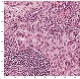

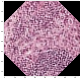

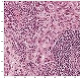

In [ ]:
# Original image
image = X_train_cancer[0]
plt.figure(figsize=(10,10), dpi=10)
plt.imshow(image)
print(image.shape)

# Rotate by 45 degrees
# Use reshape=False to keep the same image size
image1 = scipy.ndimage.rotate(image, 45, reshape=False) 
plt.figure(figsize=(10,10), dpi=10)
plt.imshow(image1)
print(image1.shape)

# Rotate by 90 degrees
# Use reshape=False to keep the same image size
image = scipy.ndimage.rotate(image, 90, reshape=False)
plt.figure(figsize=(10,10), dpi=10)
plt.imshow(image)
print(image.shape)

Process cancerous slides
We create an empty list to hold the augmented dataset. We rotate the image by a random angle for five times. Then, we flip the image and do the same thing for another four times. After this, we will augment the dataset by 11 times.

In [ ]:
temp = []
for slide_image in X_train_cancer:
    temp.append(slide_image)
    temp.append(scipy.ndimage.rotate(slide_image, randrange(360), reshape=False))
    temp.append(scipy.ndimage.rotate(slide_image, randrange(360), reshape=False))
    temp.append(scipy.ndimage.rotate(slide_image, randrange(360), reshape=False))
    temp.append(scipy.ndimage.rotate(slide_image, randrange(360), reshape=False))
    temp.append(scipy.ndimage.rotate(slide_image, randrange(360), reshape=False))
    temp.append(np.fliplr(slide_image))
    temp.append(scipy.ndimage.rotate(np.fliplr(slide_image), randrange(360), reshape=False))
    temp.append(scipy.ndimage.rotate(np.fliplr(slide_image), randrange(360), reshape=False))
    temp.append(scipy.ndimage.rotate(np.fliplr(slide_image), randrange(360), reshape=False))
    temp.append(scipy.ndimage.rotate(np.fliplr(slide_image), randrange(360), reshape=False))

X_train_cancer = temp

In [ ]:
# Print stats
print(len(X_train_cancer)) # 27456
print(len(X_val_cancer)) # 300
print(len(X_test_cancer)) # 300

27456
300
300


Now we need to process the normal slides. We take out the validation set and test set, and put the rest into the training set.

In [ ]:
# Process normal slides

# Select the same number of images as the cancerous set
# so that the overall set is balanced
X_val_normal = normal_images[0:300]
X_test_normal = normal_images[300:600]
X_train_normal = normal_images[600:]

# Print stats
print(len(X_train_normal)) # 27456
print(len(X_val_normal)) # 300
print(len(X_test_normal)) # 300

26544
300
300


In [ ]:
from sklearn.utils import shuffle

# Concatenate cancerous set and normal training set and shuffle
X_train = np.array(X_train_cancer + X_train_normal)
y_train = np.array([1] * len(X_train_cancer) + [0] * len(X_train_normal))
X_train, y_train = shuffle(X_train, y_train)

# Concatenate cancerous set and normal validation set and shuffle
X_val = np.array(X_val_cancer + X_val_normal)
y_val = np.array([1] * len(X_val_cancer) + [0] * len(X_val_normal))
X_val, y_val = shuffle(X_val, y_val)

# Concatenate cancerous set and normal test set and shuffle
X_test = np.array(X_test_cancer + X_test_normal)
y_test = np.array([1] * len(X_test_cancer) + [0] * len(X_test_normal))
X_test, y_test = shuffle(X_test, y_test)

# Print stats
print('X_train:', len(X_train))
print('y_train:', len(y_train))
print('X_val:', len(X_val))
print('y_val:', len(y_val))
print('X_test:', len(X_test))
print('y_test:', len(y_test))

X_train: 54000
y_train: 54000
X_val: 600
y_val: 600
X_test: 600
y_test: 600


## Training & Evaluation

With the dataset ready, we can start training our model. We will use InceptionV3 and transfer learning, as mentioned in the paper.

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Flatten

# Define layers:
# We will use a dropout layer to prevent overfitting. Then, we flatten the 
# dataset and feed it into a dense layer, and finally into the prediction layer.
dropout_layer = Dropout(0.1)
flatten_layer = Flatten()
dense_layer = Dense(128, activation='relu')
prediction_layer = Dense(1, activation='sigmoid')

# Define model
# We use a sequential model, and add InceptionV3 and the layers defined above
model = tf.keras.Sequential([
    base_model,
    dropout_layer,
    flatten_layer,
    dense_layer,
    prediction_layer
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 1, 1, 2048)        21802784  
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 22,065,185
Trainable params: 22,030,753
Non-trainable params: 34,432
_________________________________________________________________


We will use the RMSprop optimizer, also as mentioned in the paper. Now, we can compile the model with binary cross entropy. We use accuracy, precision and recall as metrics.

In [ ]:
# Use RMSprop with a custom learning rate
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0002)

# Compile model
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy',
              tf.keras.metrics.Precision(name='precision'),
              tf.keras.metrics.Recall(name='recall')])

Now we train the model:

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=10)

Epoch 1/10
1688/1688 [==============================] - 102s 54ms/step - loss: 0.2104 - accuracy: 0.9199 - precision: 0.9362 - recall: 0.9046 - val_loss: 0.4292 - val_accuracy: 0.8433 - val_precision: 0.9952 - val_recall: 0.6900
Epoch 2/10
1688/1688 [==============================] - 90s 54ms/step - loss: 0.0973 - accuracy: 0.9706 - precision: 0.9861 - recall: 0.9559 - val_loss: 0.3759 - val_accuracy: 0.8817 - val_precision: 0.9751 - val_recall: 0.7833
Epoch 3/10
1688/1688 [==============================] - 90s 54ms/step - loss: 0.0756 - accuracy: 0.9779 - precision: 0.9902 - recall: 0.9660 - val_loss: 0.3115 - val_accuracy: 0.8800 - val_precision: 0.9957 - val_recall: 0.7633
Epoch 4/10
1688/1688 [==============================] - 90s 53ms/step - loss: 0.0725 - accuracy: 0.9791 - precision: 0.9888 - recall: 0.9701 - val_loss: 0.3347 - val_accuracy: 0.8750 - val_precision: 0.9870 - val_recall: 0.7600
Epoch 5/10
1688/1688 [==============================] - 91s 54ms/step - loss: 0.0639 - 

Evaluate the model. In one of the trails, I got an accuracy of 92.67%.

In [ ]:
model.evaluate(X_test,y_test,batch_size=32)

19/19 [==============================] - 0s 20ms/step - loss: 0.2334 - accuracy: 0.9267 - precision: 0.9507 - recall: 0.9000


[0.23343561589717865,
 0.9266666769981384,
 0.9507042169570923,
 0.8999999761581421]

Plot the accuracy and loss of training and validation:

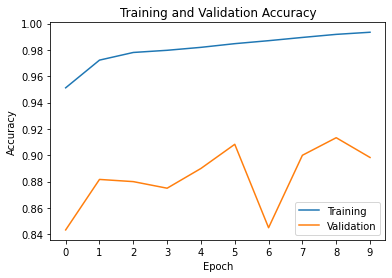

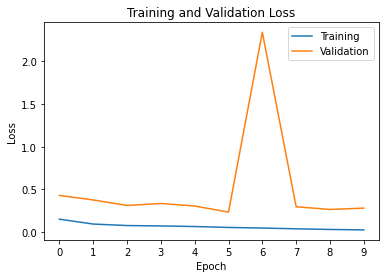

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_list = range(len(accuracy))

x = range(10)

plt.plot(epochs_list, accuracy, label='Training')
plt.plot(epochs_list, val_accuracy, label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(x)
plt.show()

plt.plot(epochs_list, loss, label='Training')
plt.plot(epochs_list, val_loss, label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xticks(x)
plt.show()

Finally, we save the model:

In [ ]:
model.save('./model.h5')

## Produce Heatmap

We can see that the model has a decent accuracy rate on the testset, so let's create a heatmap to see how the model actually behaves.

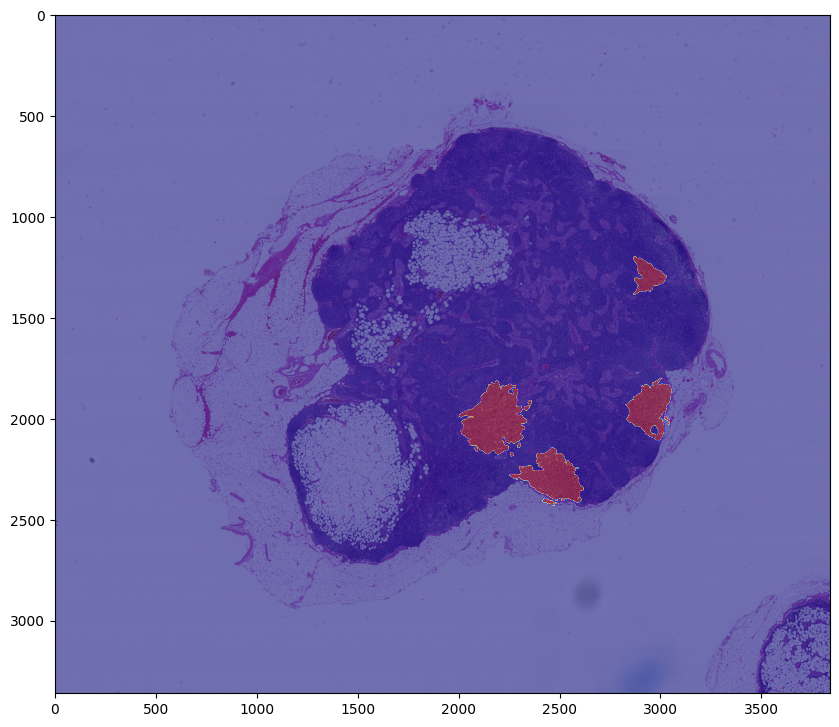

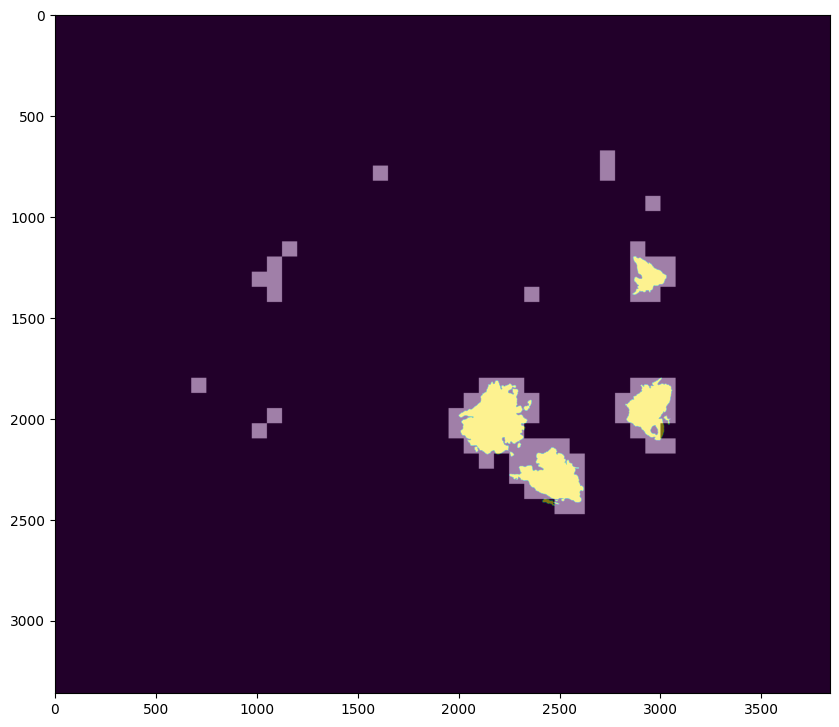

In [ ]:
level = 4
index = 16

# Plot slide image
slide_image = plot_slide(slides[index], level, mask=False, plot=False)
mask_image = plot_slide(masks[index], level, mask=True, plot=False)
plot_overlay(slide_image, mask_image)

# Plot heatmap
plot_heatmap(75, level, index, 20)

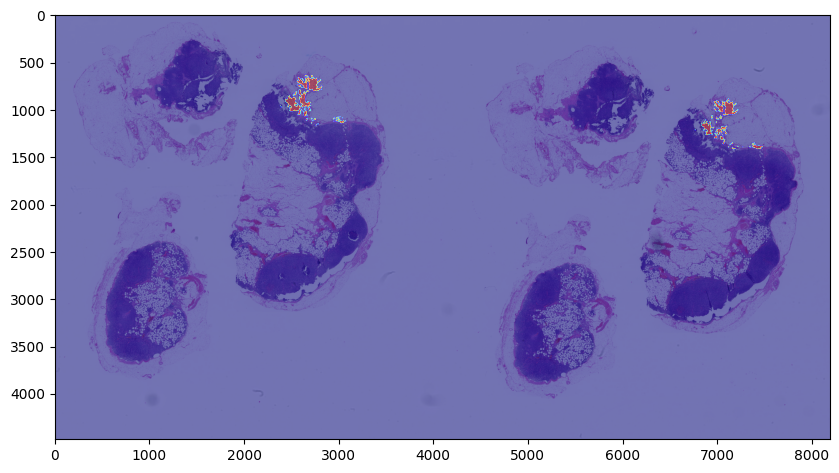

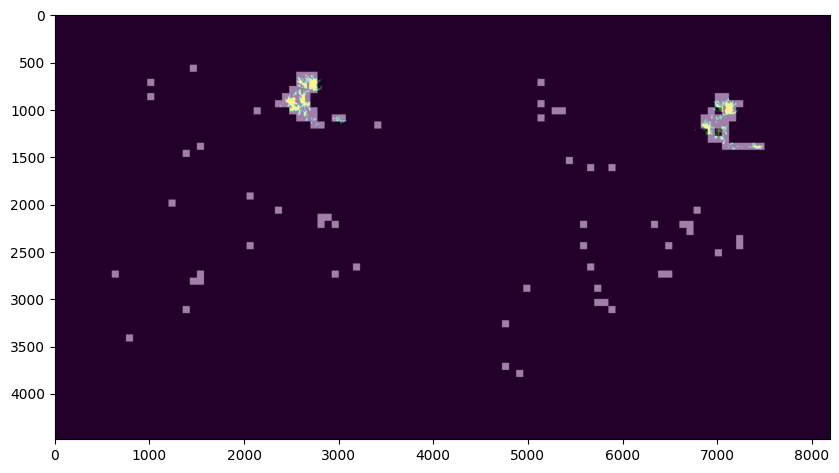

In [ ]:
level = 4
index = 18

# Plot slide image
slide_image = plot_slide(slides[index], level, mask=False, plot=False)
mask_image = plot_slide(masks[index], level, mask=True, plot=False)
plot_overlay(slide_image, mask_image)

# Plot heatmap
plot_heatmap(75, level, index, 20)

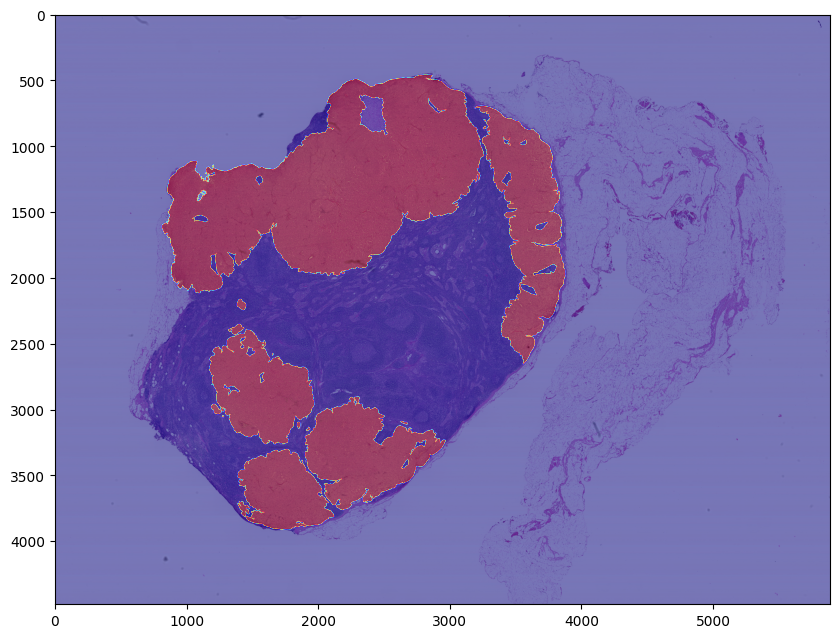

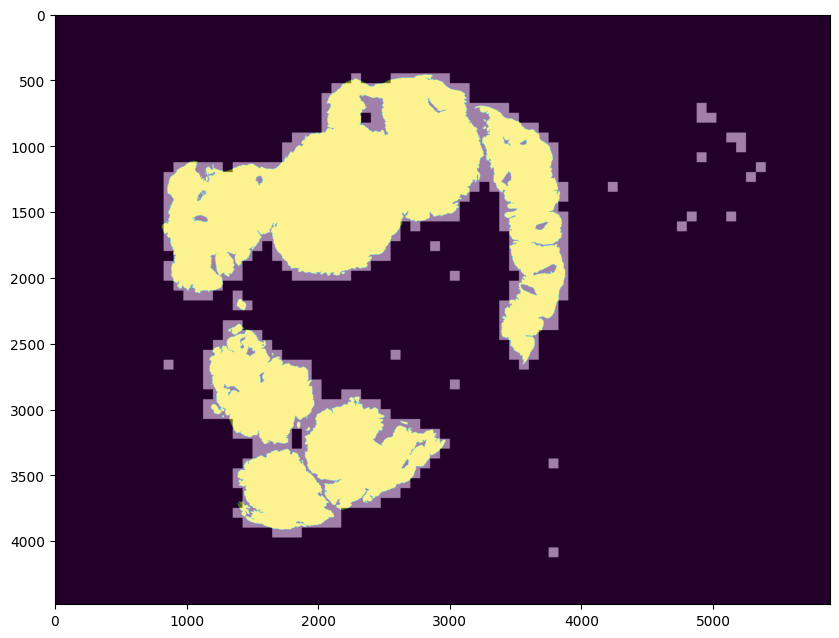

In [ ]:
level = 4
index = 20

# Plot slide image
slide_image = plot_slide(slides[index], level, mask=False, plot=False)
mask_image = plot_slide(masks[index], level, mask=True, plot=False)
plot_overlay(slide_image, mask_image)

# Plot heatmap
plot_heatmap(75, level, index, 20)

## Conclusion of Approach 1

We can see that the model has decent performance: despite making a few mistakes, it successfully covered almost all the cancerous regions on the slide. It has pretty good accuracy, precision and recall.

# Approach 2: Multiple Zoom Levels + InceptionV3

## Data Gathering

Now that we've trained a model with a single zoom layer, let's train a model with two zoom layers (4 and 5). 

In [ ]:
# Recall the slides list and masks list we created earlier
print(len(slides))
print(len(masks))

21
21


This time, instead of getting data from all slides, we divide the slides into training, validation and test. We extract all the images from the slides and put into the categories.


In [ ]:
def extract_from_slide(i, level, width=75, threshold=20):
    image_list = [] # List to hold all slides
    mask_list = [] # List to hold all masks
    label_list = [] # List to hold all labels

    num_cancer = 0
    num_normal = 0

    # Get width, height, and number of blocks on each direction
    slide_width = slides[i].level_dimensions[level][0]
    slide_height = slides[i].level_dimensions[level][1]
    num_blocks_horizontal = int(slide_width/width)
    num_blocks_vertical = int(slide_height/width)

    print('='*50)
    print('Processing tumor_%s' % slide_number[i])
    # print('- horizontal:', num_blocks_horizontal)
    # print('- vertical:', num_blocks_vertical)

    # Keep track of the number of images we extracted from the current slide
    num_images = 0

    for j in range(num_blocks_horizontal):    # Traverse horizontal block positions
        for k in range(num_blocks_vertical):  # Traverse vertical block positions
            # Read slide
            slide_image = read_slide(slides[i], 
                                        x=(j+1) * width * 2**level, 
                                        y=(k+1) * width * 2**level, 
                                        level=level, 
                                        width=width, 
                                        height=width)
                
            # Compute the percentage of tissue pixels
            # (We keep the slide only if the percentage of tissue pixels reach the threshold)
            tissue_pixels = find_tissue_pixels(slide_image)
            percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
            if percent_tissue > threshold:
                num_images += 1

                # Append image to the image list
                image_list.append(slide_image)

                # Append mask to the mask list
                mask_image = read_slide(masks[i], 
                                    x=(j+1) * width * 2**level, 
                                    y=(k+1) * width * 2**level, 
                                    level=level, 
                                    width=width, 
                                    height=width)
                mask_image = mask_image[:,:,0]  # Get the first channel of the mask
                mask_list.append(mask_image)
                    
                # Append label to the label list
                if np.sum(mask_image) > 0:  # If mask has one cancerous cell, append 1
                    label_list.append(1)
                    num_cancer += 1
                else:                       # If no cancerous cell, append 0
                    label_list.append(0)
                    num_normal += 1

    # print('Extracted %d images' % num_images)

    return image_list, mask_list, label_list, num_cancer, num_normal

### Level 5

In [ ]:
image_list_by_slide5 = []
mask_list_by_slide5 = []
label_list_by_slide5 = []

num_cancer_by_slide5 = []
num_normal_by_slide5 = []

for i in range(len(slides)):
    image_list, mask_list, label_list, num_cancer, num_normal = extract_from_slide(i, 5)
    image_list_by_slide5.append(image_list)
    mask_list_by_slide5.append(mask_list)
    label_list_by_slide5.append(label_list)

    num_cancer_by_slide5.append(num_cancer)
    num_normal_by_slide5.append(num_normal)

    print('- Cancerous:', num_cancer)
    print('- Normal:', num_normal)

Processing tumor_001
- Cancerous: 9
- Normal: 560
Processing tumor_002
- Cancerous: 2
- Normal: 306
Processing tumor_005
- Cancerous: 3
- Normal: 316
Processing tumor_012
- Cancerous: 2
- Normal: 381
Processing tumor_016
- Cancerous: 52
- Normal: 295
Processing tumor_019
- Cancerous: 5
- Normal: 260
Processing tumor_023
- Cancerous: 7
- Normal: 351
Processing tumor_031
- Cancerous: 63
- Normal: 222
Processing tumor_035
- Cancerous: 2
- Normal: 336
Processing tumor_057
- Cancerous: 7
- Normal: 291
Processing tumor_059
- Cancerous: 2
- Normal: 304
Processing tumor_064
- Cancerous: 50
- Normal: 276
Processing tumor_075
- Cancerous: 35
- Normal: 230
Processing tumor_078
- Cancerous: 316
- Normal: 483
Processing tumor_081
- Cancerous: 1
- Normal: 409
Processing tumor_084
- Cancerous: 26
- Normal: 343
Processing tumor_091
- Cancerous: 27
- Normal: 239
Processing tumor_094
- Cancerous: 21
- Normal: 694
Processing tumor_096
- Cancerous: 23
- Normal: 487
Processing tumor_101
- Cancerous: 77
- N

In [ ]:
total_cancer5 = 0
total_normal5 = 0
for i in range(len(slides)):
    total_cancer5 += num_cancer_by_slide5[i]
    total_normal5 += num_normal_by_slide5[i]

for i in range(len(slides)):
    print(i, '-', num_cancer_by_slide5[i], '-', num_cancer_by_slide5[i]/num_total)

0 - 9 - 0.0010672358591248667
1 - 2 - 0.00023716352424997035
2 - 3 - 0.0003557452863749555
3 - 2 - 0.00023716352424997035
4 - 52 - 0.006166251630499229
5 - 5 - 0.0005929088106249259
6 - 7 - 0.0008300723348748962
7 - 63 - 0.007470651013874066
8 - 2 - 0.00023716352424997035
9 - 7 - 0.0008300723348748962
10 - 2 - 0.00023716352424997035
11 - 50 - 0.005929088106249259
12 - 35 - 0.004150361674374482
13 - 316 - 0.03747183683149532
14 - 1 - 0.00011858176212498517
15 - 26 - 0.0030831258152496147
16 - 27 - 0.0032017075773745998
17 - 21 - 0.0024902170046246885
18 - 23 - 0.002727380528874659
19 - 77 - 0.00913079568362386
20 - 260 - 0.030831258152496144


### Level 4

In [ ]:
image_list_by_slide4 = []
mask_list_by_slide4 = []
label_list_by_slide4 = []

num_cancer_by_slide4 = []
num_normal_by_slide4 = []

for i in range(len(slides)):
    image_list, mask_list, label_list, num_cancer, num_normal = extract_from_slide(i, 4)
    image_list_by_slide4.append(image_list)
    mask_list_by_slide4.append(mask_list)
    label_list_by_slide4.append(label_list)

    num_cancer_by_slide4.append(num_cancer)
    num_normal_by_slide4.append(num_normal)

    print('- Cancerous:', num_cancer)
    print('- Normal:', num_normal)

Processing tumor_001
- Cancerous: 23
- Normal: 1937
Processing tumor_002
- Cancerous: 5
- Normal: 1098
Processing tumor_005
- Cancerous: 7
- Normal: 1154
Processing tumor_012
- Cancerous: 4
- Normal: 1371
Processing tumor_016
- Cancerous: 155
- Normal: 1133
Processing tumor_019
- Cancerous: 10
- Normal: 810
Processing tumor_023
- Cancerous: 9
- Normal: 1204
Processing tumor_031
- Cancerous: 194
- Normal: 695
Processing tumor_035
- Cancerous: 3
- Normal: 1280
Processing tumor_057
- Cancerous: 13
- Normal: 1043
Processing tumor_059
- Cancerous: 2
- Normal: 1070
Processing tumor_064
- Cancerous: 147
- Normal: 998
Processing tumor_075
- Cancerous: 93
- Normal: 889
Processing tumor_078
- Cancerous: 1024
- Normal: 1865
Processing tumor_081
- Cancerous: 2
- Normal: 1495
Processing tumor_084
- Cancerous: 71
- Normal: 1281
Processing tumor_091
- Cancerous: 72
- Normal: 846
Processing tumor_094
- Cancerous: 62
- Normal: 2382
Processing tumor_096
- Cancerous: 69
- Normal: 1852
Processing tumor_10

In [ ]:
total_cancer4 = 0
total_normal4 = 0
for i in range(len(slides)):
    total_cancer4 += num_cancer_by_slide4[i]
    total_normal4 += num_normal_by_slide4[i]

for i in range(len(slides)):
    print(i, '-', num_cancer_by_slide4[i], '-', num_cancer_by_slide4[i]/num_total)

0 - 23 - 0.0007605820105820106
1 - 5 - 0.00016534391534391533
2 - 7 - 0.0002314814814814815
3 - 4 - 0.00013227513227513228
4 - 155 - 0.005125661375661375
5 - 10 - 0.00033068783068783067
6 - 9 - 0.00029761904761904765
7 - 194 - 0.006415343915343916
8 - 3 - 9.92063492063492e-05
9 - 13 - 0.0004298941798941799
10 - 2 - 6.613756613756614e-05
11 - 147 - 0.004861111111111111
12 - 93 - 0.0030753968253968253
13 - 1024 - 0.033862433862433865
14 - 2 - 6.613756613756614e-05
15 - 71 - 0.002347883597883598
16 - 72 - 0.002380952380952381
17 - 62 - 0.00205026455026455
18 - 69 - 0.002281746031746032
19 - 218 - 0.007208994708994709
20 - 913 - 0.030191798941798943


### Level 3

In [ ]:
image_list_by_slide3 = []
mask_list_by_slide3 = []
label_list_by_slide3 = []
num_cancer_by_slide3 = []
num_normal_by_slide3 = []

for i in range(len(slides)):
    image_list, mask_list, label_list, num_cancer, num_normal = extract_from_slide(i, 3)
    image_list_by_slide3.append(image_list)
    mask_list_by_slide3.append(mask_list)
    label_list_by_slide3.append(label_list)
    
    num_cancer_by_slide3.append(num_cancer)
    num_normal_by_slide3.append(num_normal)

    print('- Cancerous:', num_cancer)
    print('- Normal:', num_normal)

Processing tumor_001
- Cancerous: 60
- Normal: 6799
Processing tumor_002
- Cancerous: 8
- Normal: 3546
Processing tumor_005
- Cancerous: 18
- Normal: 3518
Processing tumor_012
- Cancerous: 10
- Normal: 4586
Processing tumor_016
- Cancerous: 545
- Normal: 3509
Processing tumor_019
- Cancerous: 22
- Normal: 2657
Processing tumor_023
- Cancerous: 26
- Normal: 3920
Processing tumor_031
- Cancerous: 624
- Normal: 2178
Processing tumor_035
- Cancerous: 4
- Normal: 3740
Processing tumor_057
- Cancerous: 24
- Normal: 3354
Processing tumor_059
- Cancerous: 4
- Normal: 3807
Processing tumor_064
- Cancerous: 483
- Normal: 3322
Processing tumor_075
- Cancerous: 286
- Normal: 3166
Processing tumor_078
- Cancerous: 3584
- Normal: 7256
Processing tumor_081
- Cancerous: 5
- Normal: 5136
Processing tumor_084
- Cancerous: 198
- Normal: 4531
Processing tumor_091
- Cancerous: 215
- Normal: 3119
Processing tumor_094
- Cancerous: 212
- Normal: 8321
Processing tumor_096
- Cancerous: 198
- Normal: 6595
Proces

In [ ]:
total_cancer3 = 0
total_normal3 = 0
for i in range(len(slides)):
    total_cancer3 += num_cancer_by_slide3[i]
    total_normal3 += num_normal_by_slide3[i]

for i in range(len(slides)):
    print(i, '-', num_cancer_by_slide3[i], '-', num_cancer_by_slide3[i]/total_cancer3)

0 - 60 - 0.0056667925953910086
1 - 8 - 0.0007555723460521345
2 - 18 - 0.0017000377786173025
3 - 10 - 0.0009444654325651682
4 - 545 - 0.051473366074801664
5 - 22 - 0.00207782395164337
6 - 26 - 0.002455610124669437
7 - 624 - 0.058934642992066494
8 - 4 - 0.00037778617302606723
9 - 24 - 0.0022667170381564035
10 - 4 - 0.00037778617302606723
11 - 483 - 0.04561768039289762
12 - 286 - 0.02701171137136381
13 - 3584 - 0.33849641103135625
14 - 5 - 0.0004722327162825841
15 - 198 - 0.018700415564790327
16 - 215 - 0.020306006800151113
17 - 212 - 0.020022667170381564
18 - 198 - 0.018700415564790327
19 - 713 - 0.06734038534189649
20 - 3349 - 0.3163014733660748


### Concatenate three levels and Generate datasets

Now we try to create an 8:1:1 split of train/test/validation. We also try to make the validation and training set balanced.

In [ ]:
num_total = len(image_list_by_slide3) + len(image_list_by_slide4) + len(image_list_by_slide5) 

In [ ]:
train_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 20]
val_indices = [12, 15, 16, 17]
test_indices = [18, 19]

train_slides = []
train_labels = []

val_slides = []
val_labels = []

test_slides = []
test_labels = []

num_cancer_train = 0
num_normal_train = 0
num_cancer_val = 0
num_normal_val = 0
num_cancer_test = 0
num_normal_test = 0

for i in train_indices:
    num_cancer_train += num_cancer_by_slide5[i]
    num_normal_train += num_normal_by_slide5[i]

    num_cancer_train += num_cancer_by_slide4[i]
    num_normal_train += num_normal_by_slide4[i]

    num_cancer_train += num_cancer_by_slide3[i]
    num_normal_train += num_normal_by_slide3[i]

    train_slides = train_slides + image_list_by_slide5[i]
    train_slides = train_slides + image_list_by_slide4[i]
    train_slides = train_slides + image_list_by_slide3[i]

    train_labels = train_labels + label_list_by_slide5[i]
    train_labels = train_labels + label_list_by_slide4[i]
    train_labels = train_labels + label_list_by_slide3[i]

for i in val_indices:
    num_cancer_val += num_cancer_by_slide5[i]
    num_normal_val += num_normal_by_slide5[i]
    
    num_cancer_val += num_cancer_by_slide4[i]
    num_normal_val += num_normal_by_slide4[i]

    num_cancer_val += num_cancer_by_slide3[i]
    num_normal_val += num_normal_by_slide3[i]

    val_slides = val_slides + image_list_by_slide5[i]
    val_slides = val_slides + image_list_by_slide4[i]
    val_slides = val_slides + image_list_by_slide3[i]

    val_labels = val_labels + label_list_by_slide5[i]
    val_labels = val_labels + label_list_by_slide4[i]
    val_labels = val_labels + label_list_by_slide3[i]

for i in test_indices:
    num_cancer_test += num_cancer_by_slide5[i]
    num_normal_test += num_normal_by_slide5[i]

    num_cancer_test += num_cancer_by_slide4[i]
    num_normal_test += num_normal_by_slide4[i]

    num_cancer_test += num_cancer_by_slide3[i]
    num_normal_test += num_normal_by_slide3[i]

    test_slides = test_slides + image_list_by_slide5[i]
    test_slides = test_slides + image_list_by_slide4[i]
    test_slides = test_slides + image_list_by_slide3[i]

    test_labels = test_labels + label_list_by_slide5[i]
    test_labels = test_labels + label_list_by_slide4[i]
    test_labels = test_labels + label_list_by_slide3[i]


print('Cancer in training/All cancer:', num_cancer_train/(total_cancer5+total_cancer4+total_cancer3))
print('Normal in training/All normal:', num_normal_train/(total_normal5+total_normal4+total_normal3))
print('Cancer in val/All cancer:', num_cancer_val/(total_cancer5+total_cancer4+total_cancer3))
print('Normal in val/All normal:', num_normal_val/(total_normal5+total_normal4+total_normal3))
print('Cancer in test/All cancer:', num_cancer_test/(total_cancer5+total_cancer4+total_cancer3))
print('Normal in test/All normal:', num_normal_test/(total_normal5+total_normal4+total_normal3))

print('Cancer in training/All:', num_cancer_train/num_total)
print('Normal in training/All:', num_normal_train/num_total)
print('Cancer in val/All:', num_cancer_val/num_total)
print('Normal in val/All:', num_normal_val/num_total)
print('Cancer in test/All:', num_cancer_test/num_total)
print('Normal in test/All:', num_normal_test/num_total)

print('Cancer in training:', num_cancer_train)
print('Normal in training:', num_normal_train)
print('Cancer in val:', num_cancer_val)
print('Normal in val:', num_normal_val)
print('Cancer in test:', num_cancer_test)
print('Normal in test:', num_normal_test)

Cancer in training/All cancer: 0.8217255008859207
Normal in training/All normal: 0.6547871300676336
Cancer in val/All cancer: 0.0898187270001363
Normal in val/All normal: 0.2036123382462176
Cancer in test/All cancer: 0.08845577211394302
Normal in test/All normal: 0.1416005316861488
Cancer in training/All: 191.3968253968254
Normal in training/All: 1329.2698412698412
Cancer in val/All: 20.92063492063492
Normal in val/All: 413.3492063492063
Cancer in test/All: 20.603174603174605
Normal in test/All: 287.46031746031747
Cancer in training: 12058
Normal in training: 83744
Cancer in val: 1318
Normal in val: 26041
Cancer in test: 1298
Normal in test: 18110


We have train_slides, train_labels, val_slides, val_labels, test_slides, and test_labels. Now let's see how many images are in each:

In [ ]:
print(len(train_slides))
print(len(train_labels))
print(len(val_slides))
print(len(val_labels))
print(len(test_slides))
print(len(test_labels))
# 95802
# 95802
# 27359
# 27359
# 19408
# 19408

95802
95802
27359
27359
19408
19408


We want to make the test dataset and validation dataset more balanced. Thus, we randomly select a subset of the normal images from these sets.

In [ ]:
train_cancer = []
train_normal = []

val_cancer = []
val_normal = []

test_cancer = []
test_normal = []

for i in range(len(train_slides)):
    if train_labels[i] == 1:
        train_cancer.append(train_slides[i])
    else:
        train_normal.append(train_slides[i])

for i in range(len(val_slides)):
    if val_labels[i] == 1:
        val_cancer.append(val_slides[i])
    else:
        val_normal.append(val_slides[i])

for i in range(len(test_slides)):
    if test_labels[i] == 1:
        test_cancer.append(test_slides[i])
    else:
        test_normal.append(test_slides[i])

random.shuffle(train_cancer)
random.shuffle(train_normal)
random.shuffle(val_cancer)
random.shuffle(val_normal)
random.shuffle(test_cancer)
random.shuffle(test_normal)

train_normal = train_normal[0:48000]
val_normal = val_normal[0:1200]
test_normal = test_normal[0:1200]

print('train_cancer:', len(train_cancer))
print('train_normal:', len(train_normal))
print('val_cancer:', len(val_cancer))
print('val_normal:', len(val_normal))
print('test_cancer:', len(test_cancer))
print('test_normal:', len(test_normal))

train_cancer: 12058
train_normal: 48000
val_cancer: 1318
val_normal: 1200
test_cancer: 1298
test_normal: 1200


We now have balanced validation set and test set. We want to make the training set more balanced, so we use data augmentation, as before. There are 12058 cancerous images, and we will augment by 4 times to 48232 images. This is the approach mentioned in the paper.

In [ ]:
temp = []
for slide_image in train_cancer:
    temp.append(slide_image)
    temp.append(scipy.ndimage.rotate(slide_image, 90, reshape=False))
    temp.append(scipy.ndimage.rotate(slide_image, 180, reshape=False))
    temp.append(scipy.ndimage.rotate(slide_image, 270, reshape=False))

train_cancer = temp
print('train_cancer:', len(train_cancer))
print('train_normal:', len(train_normal))
print('val_cancer:', len(val_cancer))
print('val_normal:', len(val_normal))
print('test_cancer:', len(test_cancer))
print('test_normal:', len(test_normal))

train_cancer: 48232
train_normal: 48000
val_cancer: 1318
val_normal: 1200
test_cancer: 1298
test_normal: 1200


Sanity check

(75, 75, 3)


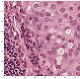

In [ ]:
image = train_cancer[100]
plt.figure(figsize=(10,10), dpi=10)
plt.imshow(image)
print(image.shape)

In [ ]:
from sklearn.utils import shuffle

# Concatenate cancerous set and normal training set and shuffle
X_train = np.array(train_cancer + train_normal)
y_train = np.array([1] * len(train_cancer) + [0] * len(train_normal))
X_train, y_train = shuffle(X_train, y_train)

# Concatenate cancerous set and normal validation set and shuffle
X_val = np.array(val_cancer + val_normal)
y_val = np.array([1] * len(val_cancer) + [0] * len(val_normal))
X_val, y_val = shuffle(X_val, y_val)

# Concatenate cancerous set and normal test set and shuffle
X_test = np.array(test_cancer + test_normal)
y_test = np.array([1] * len(test_cancer) + [0] * len(test_normal))
X_test, y_test = shuffle(X_test, y_test)

# Print stats
print('X_train:', len(X_train))
print('y_train:', len(y_train))
print('X_val:', len(X_val))
print('y_val:', len(y_val))
print('X_test:', len(X_test))
print('y_test:', len(y_test))

X_train: 96232
y_train: 96232
X_val: 2518
y_val: 2518
X_test: 2498
y_test: 2498


## Training & Evalutation

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Flatten

# Define layers:
# We will use a dropout layer to prevent overfitting. Then, we flatten the 
# dataset and feed it into a dense layer, and finally into the prediction layer.
dropout_layer = Dropout(0.1)
flatten_layer = Flatten()
dense_layer = Dense(128, activation='relu')
prediction_layer = Dense(1, activation='sigmoid')

# Define model
# We use a sequential model, and add InceptionV3 and the layers defined above
model = tf.keras.Sequential([
    base_model,
    dropout_layer,
    flatten_layer,
    dense_layer,
    prediction_layer
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 1, 1, 2048)        21802784  
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 22,065,185
Trainable params: 22,030,753
Non-trainable params: 34,432
_________________________________________________________________


We will use the RMSprop optimizer, also as mentioned in the paper. Now, we can compile the model with binary cross entropy. We use accuracy, precision and recall as metrics.

In [ ]:
# Use RMSprop with a custom learning rate
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0002)

# Compile model
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy',
              tf.keras.metrics.Precision(name='precision'),
              tf.keras.metrics.Recall(name='recall')])

Now we train the model:

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=10)

Epoch 1/10
3008/3008 [==============================] - 232s 72ms/step - loss: 0.1401 - accuracy: 0.9573 - precision: 0.9734 - recall: 0.9405 - val_loss: 1.5380 - val_accuracy: 0.6640 - val_precision: 0.8844 - val_recall: 0.4120
Epoch 2/10
3008/3008 [==============================] - 216s 72ms/step - loss: 0.0916 - accuracy: 0.9700 - precision: 0.9847 - recall: 0.9548 - val_loss: 0.6430 - val_accuracy: 0.7454 - val_precision: 0.9073 - val_recall: 0.5721
Epoch 3/10
3008/3008 [==============================] - 215s 71ms/step - loss: 0.0813 - accuracy: 0.9742 - precision: 0.9863 - recall: 0.9619 - val_loss: 0.7911 - val_accuracy: 0.6926 - val_precision: 0.9359 - val_recall: 0.4431
Epoch 4/10
3008/3008 [==============================] - 215s 71ms/step - loss: 0.0644 - accuracy: 0.9794 - precision: 0.9886 - recall: 0.9701 - val_loss: 1.3344 - val_accuracy: 0.5993 - val_precision: 0.9874 - val_recall: 0.2375
Epoch 5/10
3008/3008 [==============================] - 214s 71ms/step - loss: 0.055

Now we evaluate the model. We can see that the accuracy rate is 88.31%.

In [ ]:
model.evaluate(X_test,y_test,batch_size=32)

79/79 [==============================] - 2s 21ms/step - loss: 0.3694 - accuracy: 0.8831 - precision: 0.9523 - recall: 0.8159


[0.3694363832473755,
 0.8831064701080322,
 0.9523381590843201,
 0.8158705830574036]

Plot the accuracy and loss of training and validation:

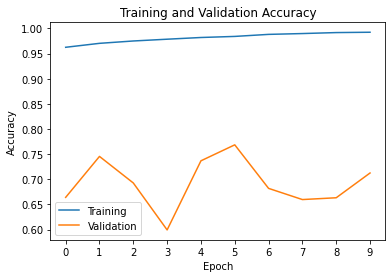

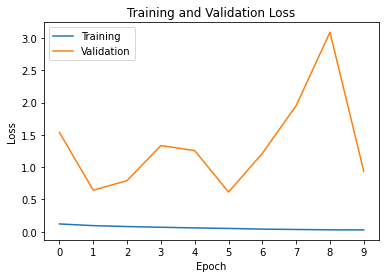

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_list = range(len(accuracy))

x = range(10)

plt.plot(epochs_list, accuracy, label='Training')
plt.plot(epochs_list, val_accuracy, label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(x)
plt.show()

plt.plot(epochs_list, loss, label='Training')
plt.plot(epochs_list, val_loss, label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xticks(x)
plt.show()

Finally, we save the model:

In [ ]:
model.save('./model2.h5')

## Produce Heatmap

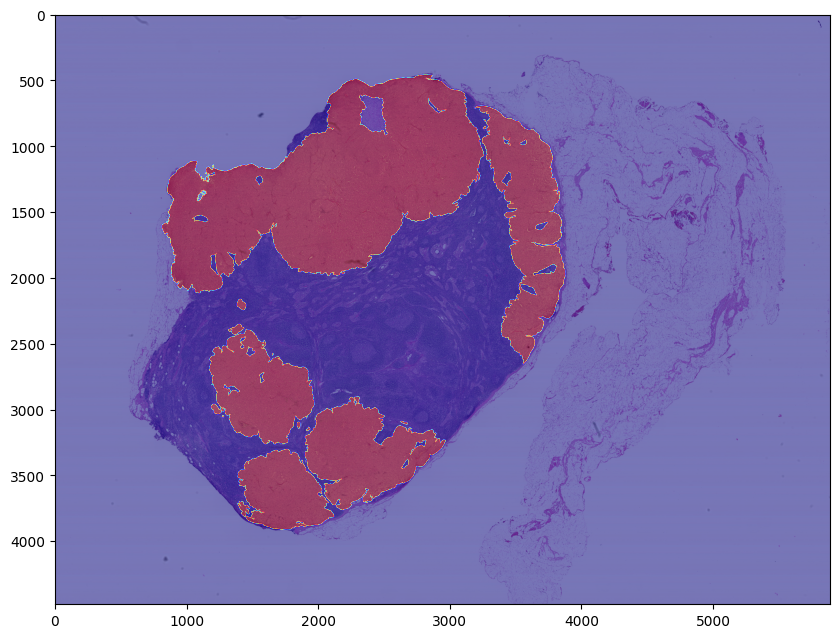

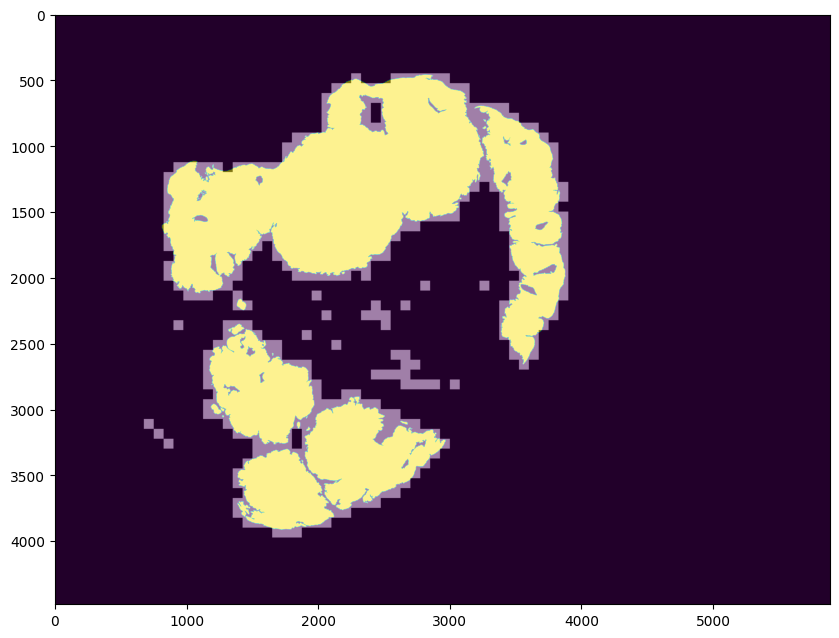

In [ ]:
level = 4
index = 20

# Plot slide image
slide_image = plot_slide(slides[index], level, mask=False, plot=False)
mask_image = plot_slide(masks[index], level, mask=True, plot=False)
plot_overlay(slide_image, mask_image)

# Plot heatmap
plot_heatmap(75, level, index, 20)

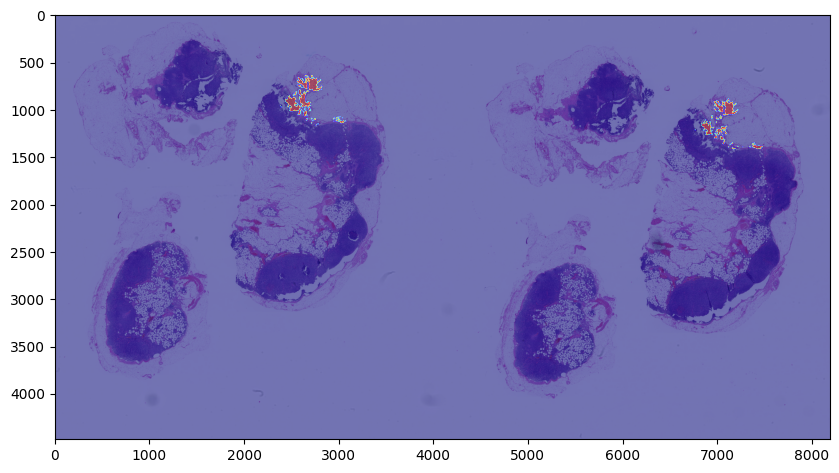

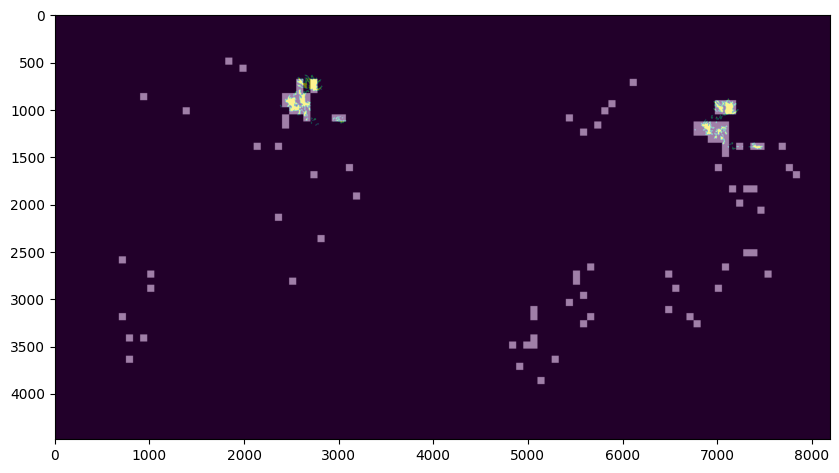

In [ ]:
level = 4
index = 18

# Plot slide image
slide_image = plot_slide(slides[index], level, mask=False, plot=False)
mask_image = plot_slide(masks[index], level, mask=True, plot=False)
plot_overlay(slide_image, mask_image)

# Plot heatmap
plot_heatmap(75, level, index, 20)

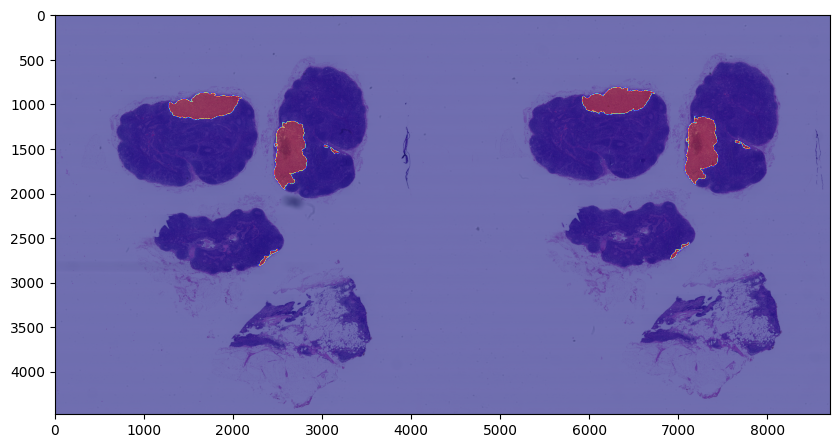

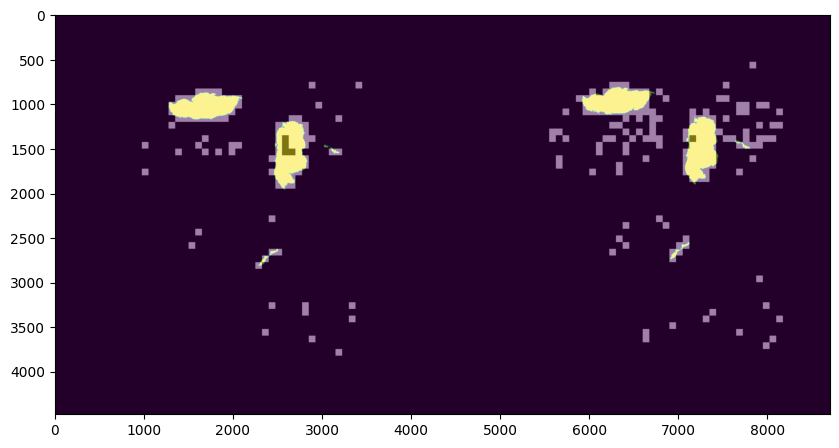

In [ ]:
level = 4
index = 19

# Plot slide image
slide_image = plot_slide(slides[index], level, mask=False, plot=False)
mask_image = plot_slide(masks[index], level, mask=True, plot=False)
plot_overlay(slide_image, mask_image)

# Plot heatmap
plot_heatmap(75, level, index, 20)

## Conclusion

We can see that this model is not as effective as the first one. Despite correctly labeled the cancerous regions, it still mislabeled quite a few normal patches as cancerous (i.e., false alarms).

# Takeaways


- The lower level of zoom we use, the more data we get, and the more accurate the model gets.

- Using only one level to train the model seemingly shows better performance than using multiple levels.

- The one-level model performed surprisingly well. Despite making a few mistakes, it successfully covered almost all the cancerous regions on the slide. It has pretty good accuracy, precision and recall. This is probably due to the fact that the data is more balanced and evenly spreaded (since we extract all images first and then do train/val/test split). It is still yet to see how this model will perform on new data. Still, the performance of this model is very satisfying.

- When I trained the InceptionV3 model with only level 4 and level 5, the training accuracy increases and the training loss decreases, but the validation accuracy and loss stays exactly the same. After close inspection, I found that it predicted all batches to be normal. I think this was due to the model getting stuck at a local minima. Thus, I decided to add more data and included level 3. The results improved immediately.

- However, the multi-level model did not perform as well as I expected, and there is no obvious performance boost. This is probably due to differences in preprocessing and model selection. For example, the paper used 299x299 batches and only look at the middle part, while I used 75x75 batches and look at the whole image. Also, the train/val/test spliting process might be problematic, since the accuracy rate on three sets are very different from each other. 